## Prepare Notebook

In [1]:
from causalml.inference.meta import(
    BaseRClassifier,
    BaseSClassifier,
    BaseTClassifier,
    BaseXClassifier,
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import (
    HistGradientBoostingClassifier,
    HistGradientBoostingRegressor,
)
from sklearn.preprocessing import OrdinalEncoder

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "png"

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


## Read Data

Data set: [RetailHero.ai contest data:](https://ods.ai/competitions/x5-retailhero-uplift-modeling/data)

https://nbviewer.org/github/maks-sh/scikit-uplift/blob/master/notebooks/RetailHero_EN.ipynb

In [2]:
from pathlib import Path

data_path = Path("/Users/juanitorduz/Downloads/retailhero-uplift/data")

clients_df = pd.read_csv(
    data_path / "clients.csv",
    parse_dates=["first_issue_date", "first_redeem_date"]
)
uplift_train_df = pd.read_csv(data_path / "uplift_train.csv")
uplift_test_df = pd.read_csv(data_path / "uplift_test.csv")

- `clients_df` data:

In [3]:
clients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400162 entries, 0 to 400161
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   client_id          400162 non-null  object        
 1   first_issue_date   400162 non-null  datetime64[ns]
 2   first_redeem_date  364693 non-null  datetime64[ns]
 3   age                400162 non-null  int64         
 4   gender             400162 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 15.3+ MB


- `uplift_train_df` data:

In [4]:
uplift_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200039 entries, 0 to 200038
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   client_id      200039 non-null  object
 1   treatment_flg  200039 non-null  int64 
 2   target         200039 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


- `uplift_test_df` data:

In [5]:
uplift_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200123 entries, 0 to 200122
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   client_id  200123 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


## EDA

In [6]:
assert clients_df.shape[0] == clients_df["client_id"].nunique()
assert uplift_train_df.shape[0] == uplift_train_df["client_id"].nunique()
assert uplift_test_df.shape[0] == uplift_test_df["client_id"].nunique()

print(f"""
clients_id
----------
clients_df: {clients_df["client_id"].nunique()}
uplift_train_df: {uplift_train_df["client_id"].nunique()}
uplift_test_df: {uplift_test_df["client_id"].nunique()}
""")


clients_id
----------
clients_df: 400162
uplift_train_df: 200039
uplift_test_df: 200123



In [7]:
clients_df["gender"].value_counts()

U    185706
F    147649
M     66807
Name: gender, dtype: int64

In [8]:
good_age_mask = "10 < age < 100"

print(f"""
Rows with age outliers: 
{1 - clients_df.query(good_age_mask).shape[0] / clients_df.shape[0]: 0.2%}
""")


Rows with age outliers: 
 0.37%



In [9]:
uplift_train_df["target"].value_counts()

1    124002
0     76037
Name: target, dtype: int64

In [10]:
na_client_ids = clients_df.query('first_redeem_date.isnull()')['client_id'].to_numpy()

uplift_train_df.query(f"client_id.isin(@na_client_ids)").target.value_counts()

0    11159
1     6387
Name: target, dtype: int64

<AxesSubplot:xlabel='first_issue_date', ylabel='count'>

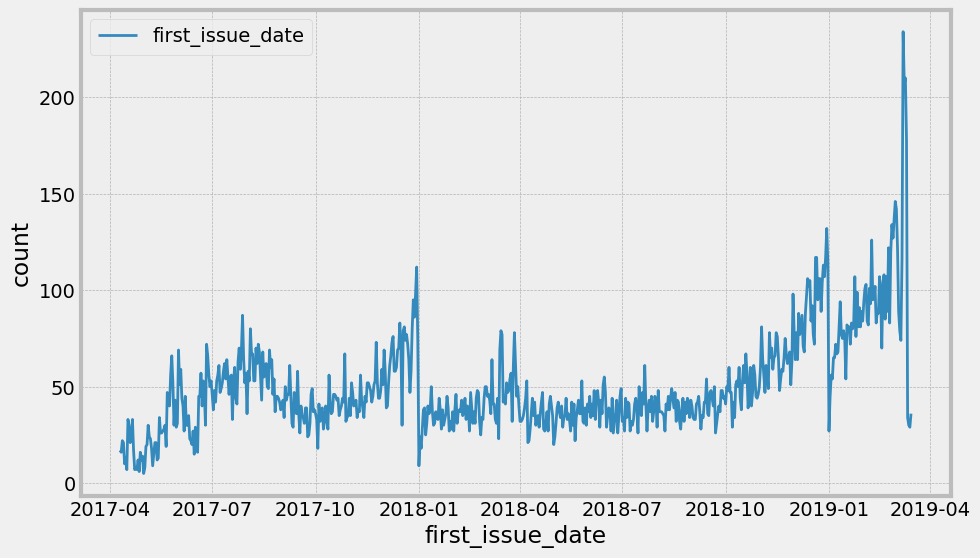

In [11]:
fig, ax = plt.subplots()

clients_df \
    .query("first_redeem_date.isnull()") \
    .assign(first_issue_date =  lambda x: x["first_issue_date"].dt.date) \
    .groupby(["first_issue_date"], as_index=False) \
    .agg(count=("client_id", "count")) \
    .pipe((sns.lineplot, "data"),
        x="first_issue_date",
        y="count",
        label="first_issue_date",
        ax=ax,
    )

In [12]:
uplift_train_df \
    .groupby(["treatment_flg", "target"], as_index=False) \
    .agg(combination_count=("client_id", "count")) \
    .assign(
        total = lambda x: x["combination_count"].sum(),
        share = lambda x: x["combination_count"] / x["total"],
    )

,treatment_flg,target,combination_count,total,share
0,0,0,39695,200039,0.198436
1,0,1,60363,200039,0.301756
2,1,0,36342,200039,0.181675
3,1,1,63639,200039,0.318133


In [13]:
uplift_train_df \
    .groupby(["treatment_flg"], as_index=False) \
    .agg(combination_count=("client_id", "count")) \
    .assign(
        total = lambda x: x["combination_count"].sum(),
        share = lambda x: x["combination_count"] / x["total"],
    )

,treatment_flg,combination_count,total,share
0,0,100058,200039,0.500192
1,1,99981,200039,0.499808


[Text(0.5, 0, 'date'), Text(0, 0.5, 'count')]

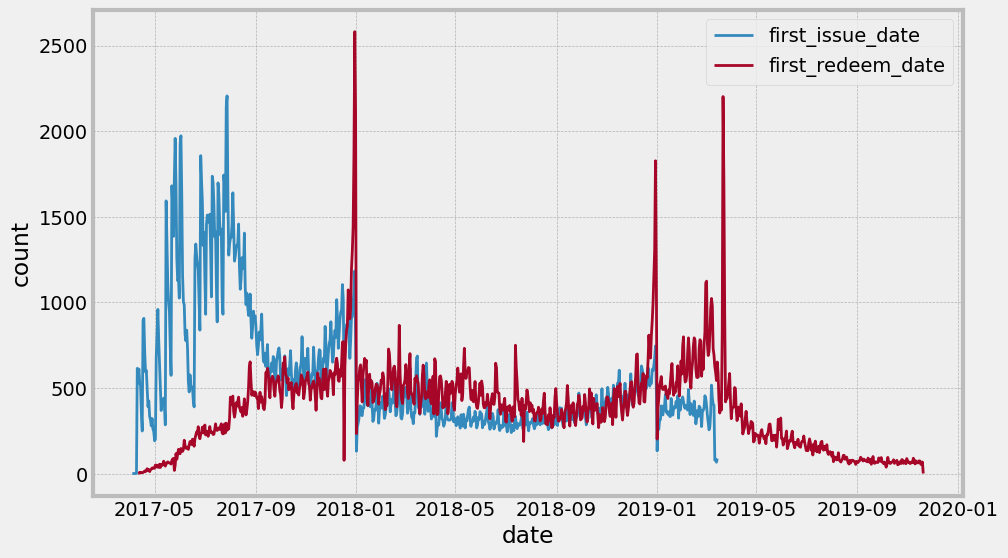

In [14]:
fig, ax = plt.subplots()

clients_df \
    .assign(first_issue_date =  lambda x: x["first_issue_date"].dt.date) \
    .groupby(["first_issue_date"], as_index=False) \
    .agg(count=("client_id", "count")) \
    .pipe((sns.lineplot, "data"),
        x="first_issue_date",
        y="count",
        label="first_issue_date",
        ax=ax,
    )

clients_df \
    .assign(first_redeem_date =  lambda x: x["first_redeem_date"].dt.date) \
    .groupby(["first_redeem_date"], as_index=False) \
    .agg(count=("client_id", "count")) \
    .pipe((sns.lineplot, "data"),
        x="first_redeem_date",
        y="count",
        label="first_redeem_date",
        ax=ax,
    )

ax.set(xlabel="date", ylabel="count")

## Prepare Data

In [15]:
transformation_map = {
    "first_issue_time": lambda x: (x["first_issue_date"] -  pd.Timestamp("2017-01-01")).dt.days,
    "first_redeem_time" : lambda x: (x["first_redeem_date"] -  pd.Timestamp("2017-01-01")).dt.days,
    "issue_redeem_delay": lambda x: (x["first_redeem_time"] - x["first_issue_time"]) 
}

features_df = clients_df.copy() \
    .query(good_age_mask) \
    .set_index("client_id") \
    .assign(**transformation_map) \
    .drop(columns=["first_issue_date", "first_redeem_date"])


data_df = pd.merge(
    left=features_df,
    right=(
        uplift_train_df
        .copy()
        .set_index("client_id")
    ),
    left_index=True,
    right_index=True,
    how="inner"
)

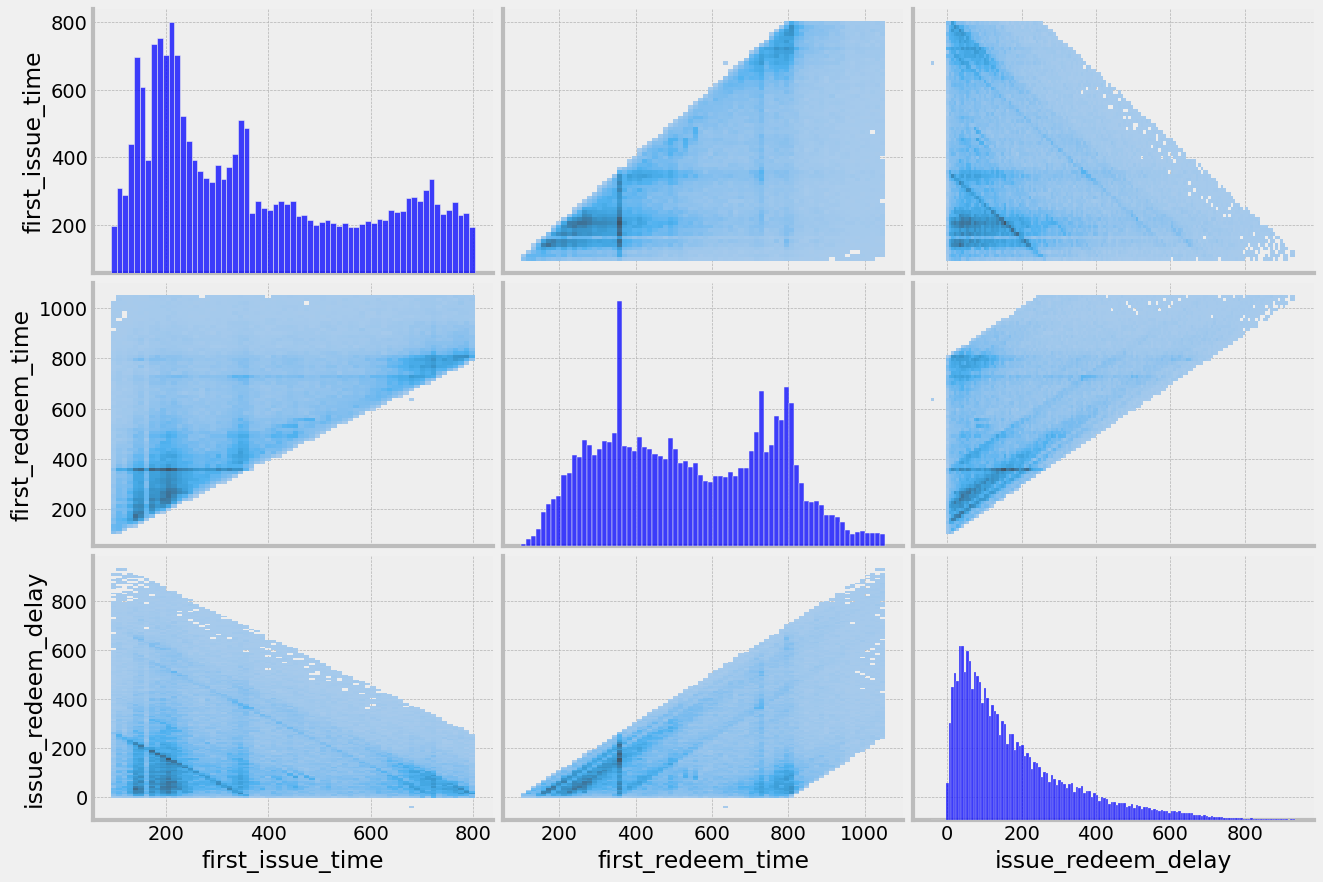

In [16]:
sns.pairplot(
    data=data_df[[
        "first_issue_time",
        "first_redeem_time",
        "issue_redeem_delay",
    ]],
    kind="hist",
    height=3,
    aspect=1.5
)

In [17]:
from sklearn.model_selection import train_test_split

target_col = "target"
treatment_col = "treatment_flg"

y = data_df[target_col]
w = data_df[treatment_col]
x = data_df.drop(columns=[treatment_col, target_col])

idx_train, idx_val = train_test_split(
    data_df.index, test_size=0.3, random_state=123
)

x_train = x.loc[idx_train]
x_val = x.loc[idx_val]

w_train = w.loc[idx_train]
w_val = w.loc[idx_val]

y_train = y.loc[idx_train]
y_val = y.loc[idx_val]

In [18]:
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(x_train[["gender"]])

x_train_transformed = x_train.assign(
    gender = lambda x: ordinal_encoder.transform(x[["gender"]])
)

x_val_transformed = x_val.assign(
    gender = lambda x: ordinal_encoder.transform(x[["gender"]])
)

In [19]:
propensity_model = HistGradientBoostingClassifier(categorical_features=[0])

propensity_model.fit(X=x_train_transformed, y=y_train)
p_train = propensity_model.predict_proba(X=x_train_transformed)
p_val = propensity_model.predict_proba(X=x_val_transformed) 

p_train = pd.Series(p_train[:, 0], index=idx_train)
p_val = pd.Series(p_val[:, 0], index=idx_val)

In [20]:
from dataclasses import dataclass

@dataclass
class Data:
    x: pd.DataFrame
    x_transformed: np.array
    y: pd.Series
    treatment: pd.Series
    p: pd.Series

data_train = Data(
    x=x_train,
    x_transformed=x_train_transformed,
    y=y_train,
    treatment=w_train,
    p=p_train
)

data_val = Data(
    x=x_val,
    x_transformed=x_val_transformed,
    y=y_val,
    treatment=w_val,
    p=p_val
)

## Models

### S-Learner

In [21]:
s_learner = BaseSClassifier(
    learner=HistGradientBoostingClassifier(categorical_features=[0])
)

s_ate = s_learner.estimate_ate(
    X=data_train.x_transformed,
    treatment=data_train.treatment,
    y=data_train.y
)

### T-Learner

In [22]:
t_learner = BaseTClassifier(
    learner=HistGradientBoostingClassifier(categorical_features=[0])
)

t_ate_lwr, t_ate, t_ate_upr = t_learner.estimate_ate(
    X=data_train.x_transformed,
    treatment=data_train.treatment,
    y=data_train.y)

### X-Learner

In [23]:
x_learner = BaseXClassifier(
    outcome_learner=HistGradientBoostingClassifier(categorical_features=[0]),
    effect_learner=HistGradientBoostingRegressor(categorical_features=[0]),
)

x_ate_lwr, x_ate, x_ate_upr = x_learner.estimate_ate(
    X=data_train.x_transformed,
    treatment=data_train.treatment,
    y=data_train.y,
    p=data_train.p
)

In [24]:
y_train_pred_s = s_learner.predict(X=data_train.x_transformed, treatment=data_train.treatment)
y_train_pred_t = t_learner.predict(X=data_train.x_transformed, treatment=data_train.treatment)
y_train_pred_x = x_learner.predict(X=data_train.x_transformed, treatment=data_train.treatment, p=data_train.p)

y_val_pred_s = s_learner.predict(X=data_val.x_transformed, treatment=data_val.treatment)
y_val_pred_t = t_learner.predict(X=data_val.x_transformed, treatment=data_val.treatment)
y_val_pred_x = x_learner.predict(X=data_val.x_transformed, treatment=data_val.treatment, p=data_val.p)

X has feature names, but HistGradientBoostingClassifier was fitted without feature names
X has feature names, but HistGradientBoostingClassifier was fitted without feature names
X has feature names, but HistGradientBoostingClassifier was fitted without feature names
X has feature names, but HistGradientBoostingClassifier was fitted without feature names


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


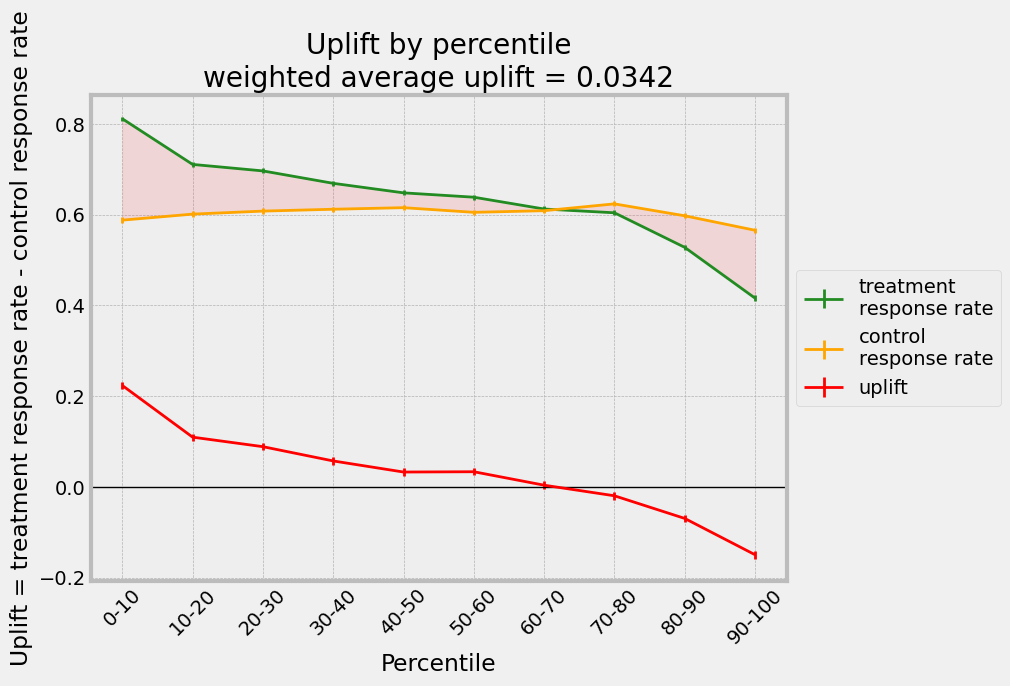

In [25]:
from sklift.viz import plot_uplift_by_percentile

ax = plot_uplift_by_percentile(
    y_true=data_train.y,
    uplift=y_train_pred_x.flatten(),
    treatment=data_train.treatment,
    strategy="overall",
    kind="line"
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

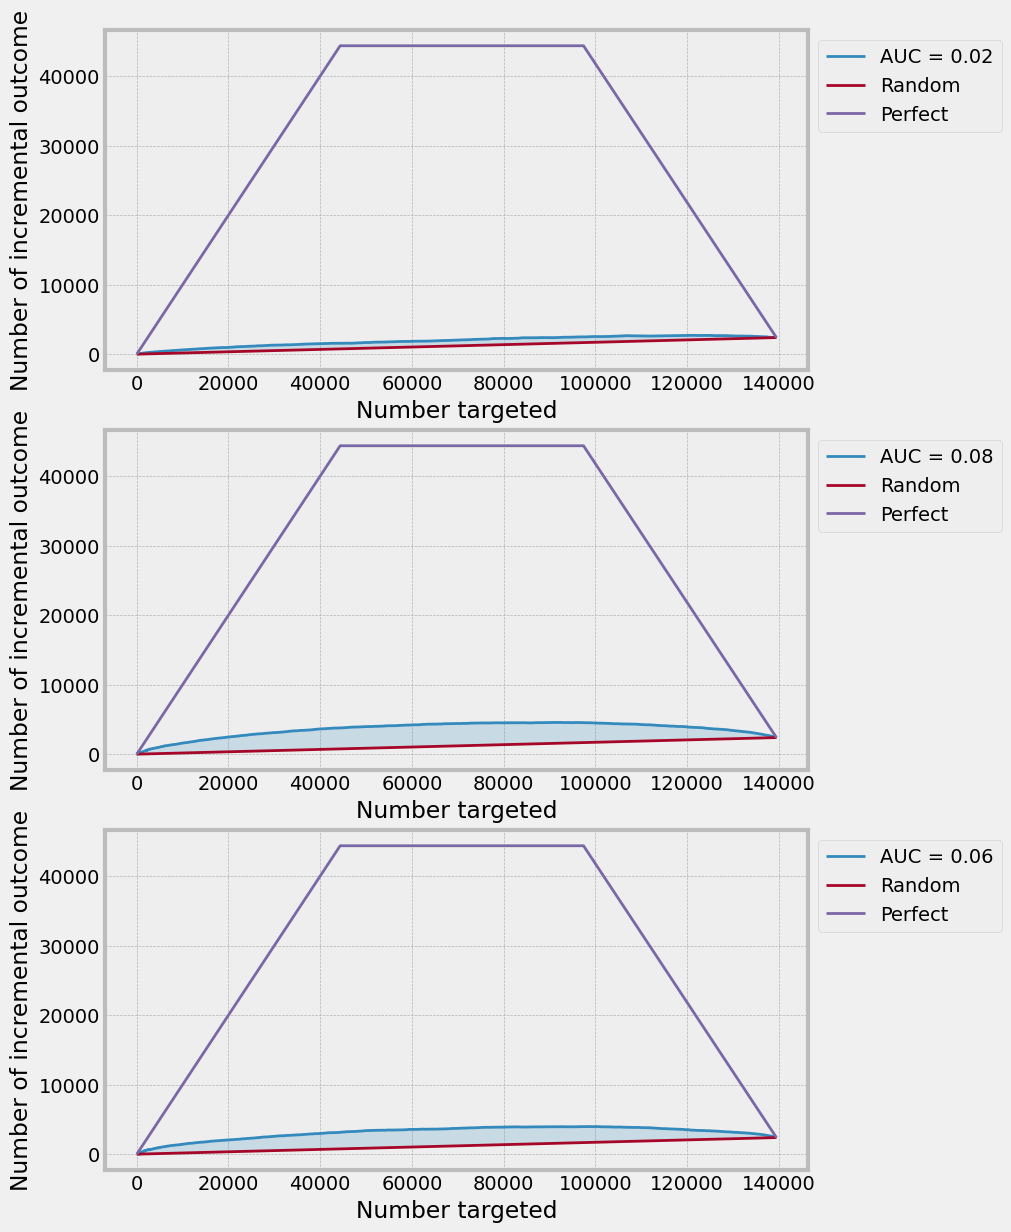

In [26]:
from sklift.viz import plot_qini_curve

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), layout="constrained")

plot_qini_curve(
    y_true=data_train.y,
    uplift=y_train_pred_s.flatten(),
    treatment=data_train.treatment,
    perfect=True,
    ax=ax[0]
)
plot_qini_curve(
    y_true=data_train.y,
    uplift=y_train_pred_t.flatten(),
    treatment=data_train.treatment,
    perfect=True,
    ax=ax[1]
)
plot_qini_curve(
    y_true=data_train.y,
    uplift=y_train_pred_x.flatten(),
    treatment=data_train.treatment,
    perfect=True,
    ax=ax[2]
);

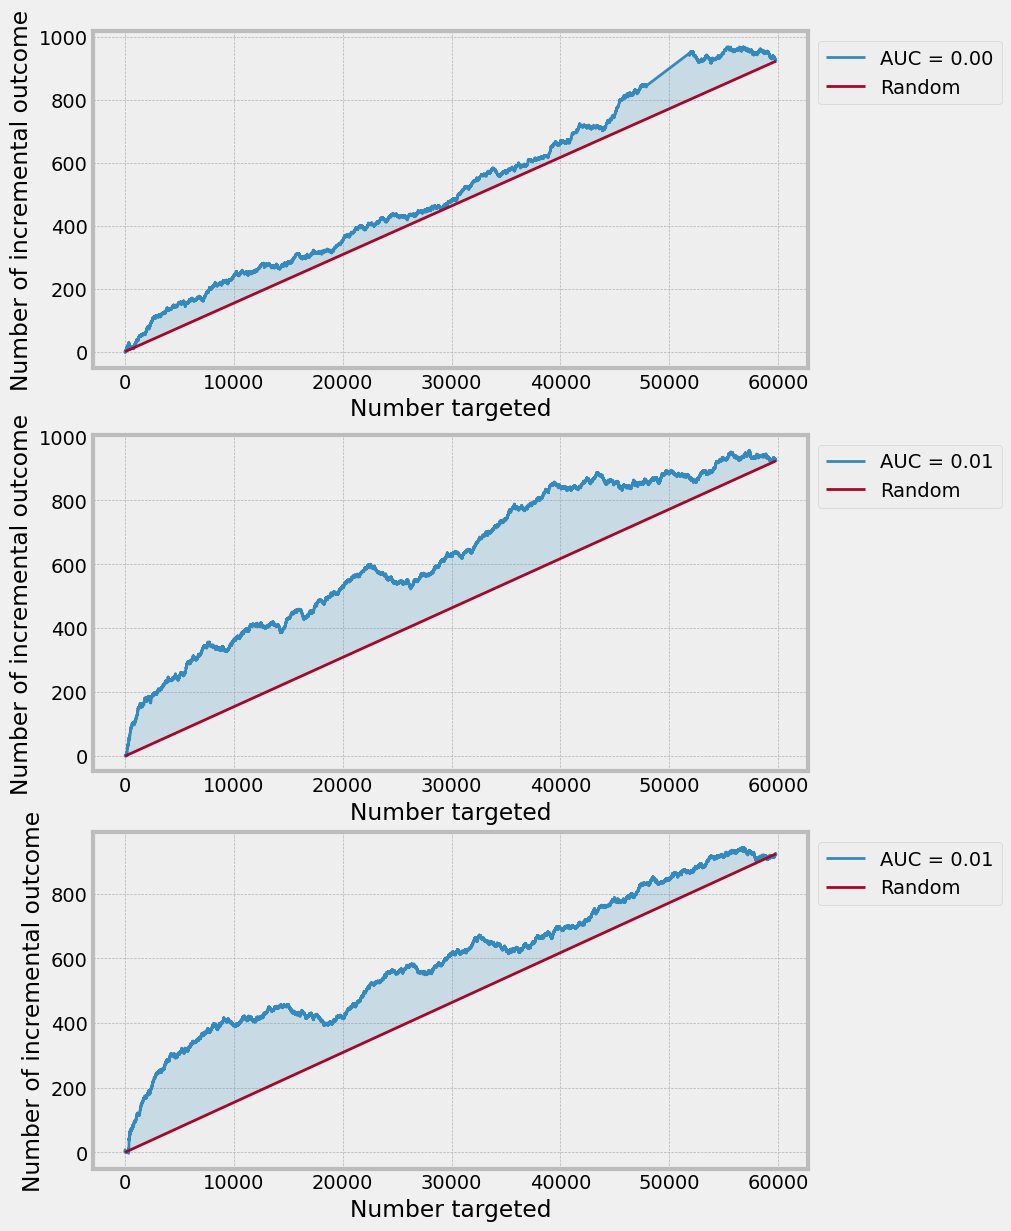

In [27]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), layout="constrained")

plot_qini_curve(
    y_true=data_val.y,
    uplift=y_val_pred_s.flatten(),
    treatment=data_val.treatment,
    perfect=False,
    ax=ax[0]
)
plot_qini_curve(
    y_true=data_val.y,
    uplift=y_val_pred_t.flatten(),
    treatment=data_val.treatment,
    perfect=False,
    ax=ax[1]
)
plot_qini_curve(
    y_true=data_val.y,
    uplift=y_val_pred_x.flatten(),
    treatment=data_val.treatment,
    perfect=False,
    ax=ax[2]
)

In [28]:
t_learner.models_c[1]
t_learner.models_t[1]

HistGradientBoostingClassifier(categorical_features=[0])

In [29]:
x_learner.models_mu_c[1]
x_learner.models_mu_t[1]
x_learner.models_tau_c[1]
x_learner.models_tau_t[1]

HistGradientBoostingRegressor(categorical_features=[0])